## TODO

- [ ] 

## Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## Getting data

In [3]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [4]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [5]:
fold_id = 0

In [6]:
X_train, y_train, X_test, y_test = X_train_list[fold_id], Y_train_list[fold_id], X_test_list[fold_id], Y_test_list[fold_id]

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(263, 90, 32)
(263,)
(90, 90, 32)
(90,)


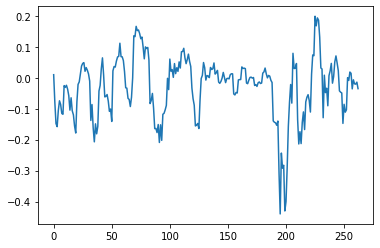

In [8]:
plt.plot(y_train)

## Preprocess for Dart

### Convert data to `TimeSeries`

In [9]:
from darts import TimeSeries

In [10]:
df = ApiCall().read_local(data='train')
df_test = ApiCall().read_local(data='test')

In [11]:
target_name = "[%]_Bitcoin_growth_rate_on_Horizon=7"
bitcoin_price_name = "[+]_[T]_Bitcoin_Price"

In [12]:
df.head(1).T

,0
date,2018-02-01
[AVG]_[NH]_mean_hash_rate,20541093181877600256.0
[+]_[NH]_Days_Till_Halving,830
[//]_[AV]_Stock-to-Flow_Ratio,5642.90322
[+]_[NH]_Circulating_Supply,16839700.0
[+]_[NH]_Issuance,2000.0
[+]_[NH]_Number_of_Active_Addresses,842398
[+]_[NH]_Mean_Block_Interval,377
[+]_[NH]_Number_of_Transactions,257504
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,27026398


In [13]:
# Set index as datetime
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.shape

(1406, 32)

In [14]:
df.sort_index()

,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,...,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,2.054109e+19,830,5642.903220,16839700.00,2000.00,842398,377,257504,27026398,110,...,0.003691,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.235616
2018-02-02,2.170824e+19,829,5641.695528,16841800.00,2100.00,854253,385,235750,26955617,110,...,0.002557,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.260491
2018-02-03,2.073919e+19,828,5641.015128,16843775.00,1975.00,714655,384,194733,26886977,110,...,0.001970,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.230759
2018-02-04,2.280248e+19,827,5632.191528,16846000.00,2225.00,720904,349,173509,26753036,110,...,0.005174,24,4103680,1674480,540698,132009,15830,1532,8176.460616,-0.418350
2018-02-05,2.411984e+19,826,5626.186626,16848312.50,2312.50,903239,338,216178,26562089,111,...,0.003859,11,4036425,1668996,541030,131987,15813,1519,6891.934414,-0.617751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,1.895333e+20,877,107683.375209,18890443.75,1050.00,1009846,335,289971,39196439,92,...,0.001035,31,6033537,2468409,663251,132374,13950,2057,53765.796483,0.000076
2021-12-04,1.690595e+20,876,107627.370170,18891412.50,968.75,966373,365,253519,39269124,90,...,0.001798,25,6045160,2473113,664015,132441,13979,2061,48962.920993,-0.113946
2021-12-05,1.869669e+20,875,107497.322411,18892450.00,1037.50,966666,342,215047,39150342,90,...,0.001013,18,6056667,2476280,664358,132558,13969,2067,49174.902908,-0.163230


In [15]:
df = df[df.index < "2021-08-01"]

In [16]:
# Set index as datetime
df_test["date"] = pd.to_datetime(df_test["date"])
df_test.set_index("date", inplace=True)
df_test.shape

(457, 32)

In [17]:
# Drop days to clearly separate test from rest
df_test = df_test[df_test.index > df.sort_index().last_valid_index()]

### Create `features_train`, `features_test`, `target_train`, `target_test`

`features` are our past covariates

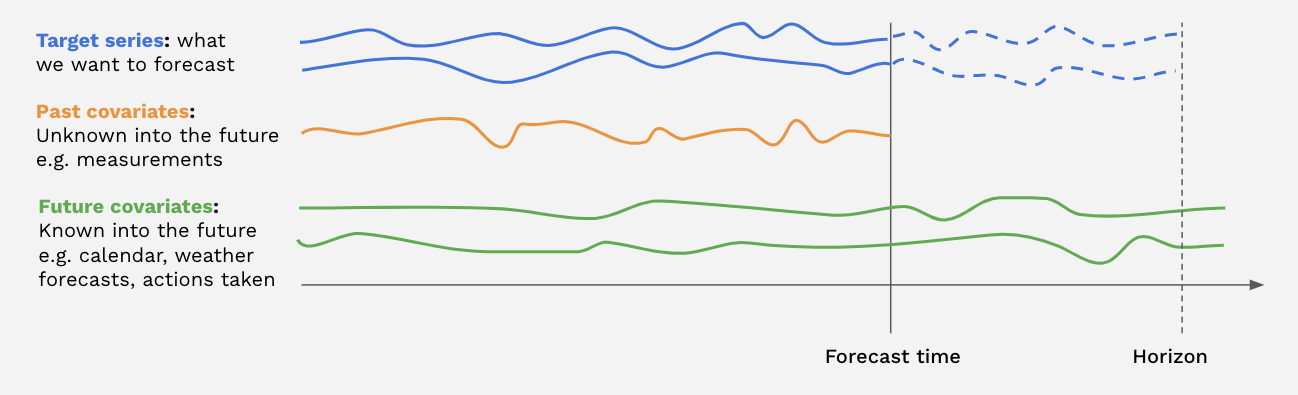

In [18]:
features = TimeSeries.from_dataframe(df.drop(columns=target_name)).astype(np.float32)
target = TimeSeries.from_dataframe(df[[target_name]]).astype(np.float32)

In [19]:
features_test = TimeSeries.from_dataframe(df_test.drop(columns=target_name)).astype(np.float32)
target_test = TimeSeries.from_dataframe(df_test[[target_name]]).astype(np.float32)

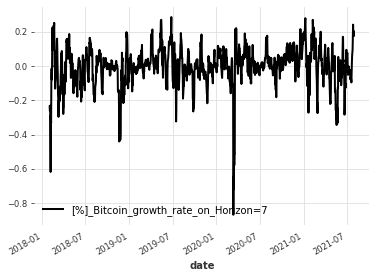

In [20]:
target.plot()

In [21]:
features_train, features_val = features.split_before(pd.Timestamp("2021-03"))
target_train, target_val = target.split_before(pd.Timestamp("2021-03"))

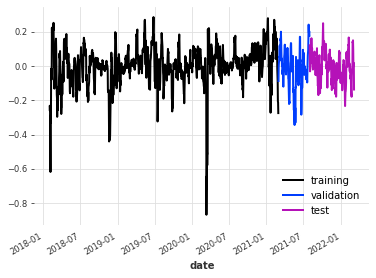

In [22]:
target_train.plot(label="training")
target_val.plot(label="validation")
target_test.plot(label="test")

### Scaling

Let's scale our covariate features. Not our target.

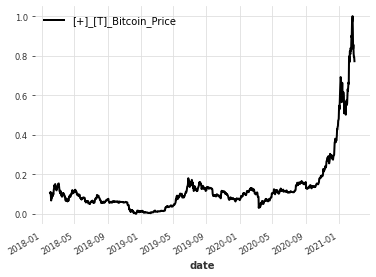

In [23]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
features_train = scaler.fit_transform(features_train)
features_train[bitcoin_price_name].plot()

## Dart Models

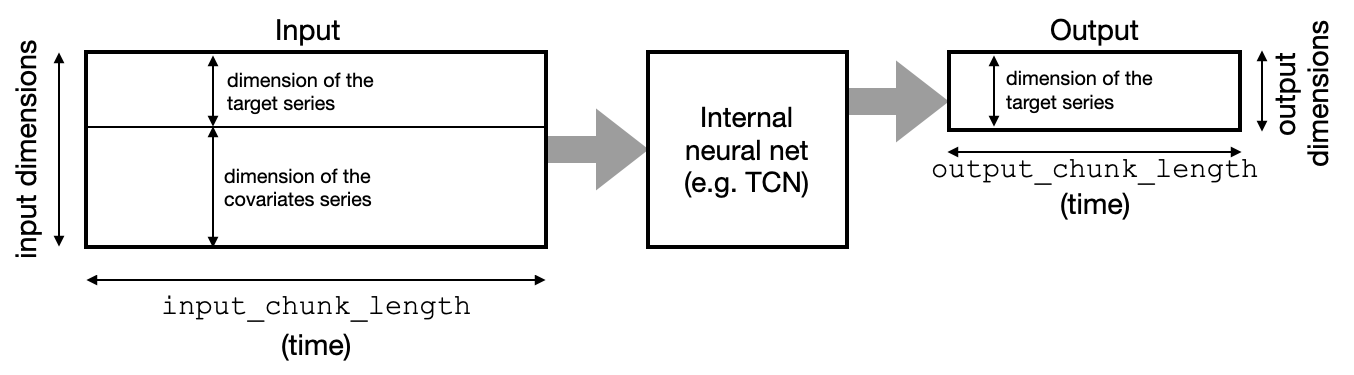

In [24]:
input_chunk_length = 30
output_chunk_length = 7 # TODO: should I use 1 or 7 here?

In [ ]:
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=input_chunk_length, 
                    output_chunk_length=output_chunk_length)

model.fit(series=target_train,
    past_covariates=features_train,
    val_series=target_val,
    val_past_covariates=features_val,
    verbose=True,
)

In [27]:
preds = model.predict(series=target_train, past_covariates=features_train, n=7)

Predicting: 33it [00:00, ?it/s]

In [ ]:
from darts.models import TransformerModel
model_transformer = TransformerModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length)

model.fit(series=target_train,
    past_covariates=features_train,
    val_series=target_val,
    val_past_covariates=features_val,
    verbose=True,
)

[2022-03-08 19:39:46,124] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1028 samples.
[2022-03-08 19:39:46,124] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1028 samples.
[2022-03-08 19:39:46,129] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-08 19:39:46,129] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model crea

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### Backtesting!

In [37]:
historical_forecasts_test = model.historical_forecasts(series=target_test,
                           past_covariates=scaler.transform(features_test),
                           start=0.6,
                           forecast_horizon=7,
                           stride=1,
                           retrain=False, 
                           verbose=False)

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

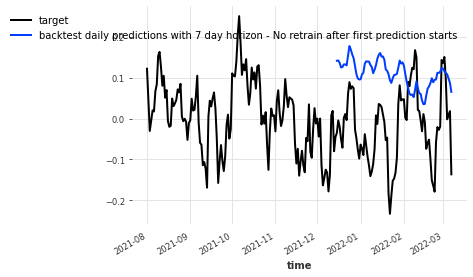

In [39]:
%matplotlib inline
target_test.plot(label='target')
historical_forecasts_test.plot(label='backtest daily predictions with 7 day horizon - No retrain after first prediction starts')

In [32]:
historical_forecasts = model.historical_forecasts(series=target_train,
                           past_covariates=features_train,
                           start=0.7,
                           forecast_horizon=7,
                           stride=1,
                           retrain=False, 
                           verbose=True)

  0%|          | 0/332 [00:00<?, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

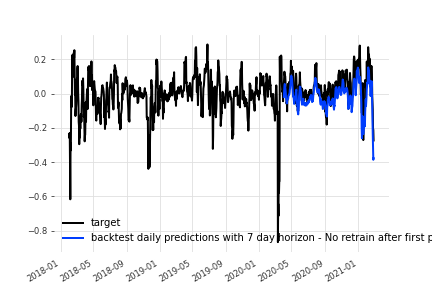

In [34]:
%matplotlib widget
target_train.plot(label='target')
historical_forecasts.plot(label='backtest daily predictions with 7 day horizon - No retrain after first prediction starts')

In [ ]:
# TODO : undertand why the backtesting leaks. Maybe we have to "retrain=True" ? 

## Statistics

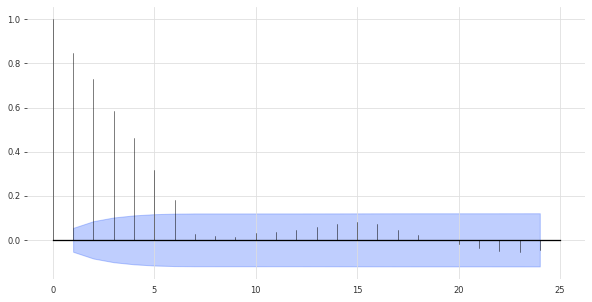

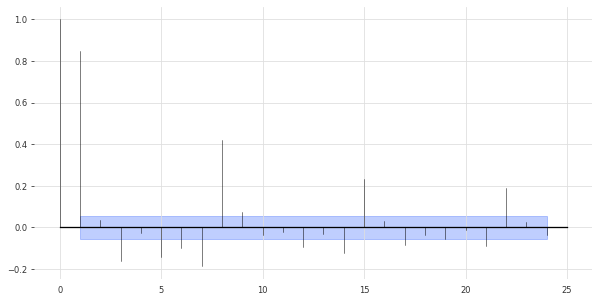

In [78]:
from darts.utils.statistics import plot_acf, plot_pacf
plot_acf(ts_train[target_name])
plot_pacf(ts_train[target_name])

## Metrics

In [ ]:
from darts.metrics import mape
mape(series, combined_forecast)

## Data viz exploration

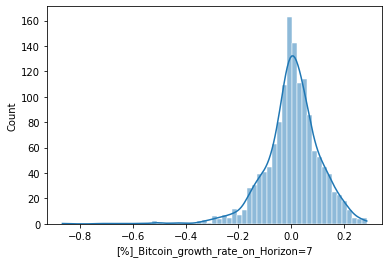

In [7]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

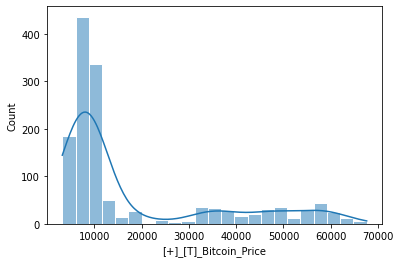

In [8]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [16]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model = model
        model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();


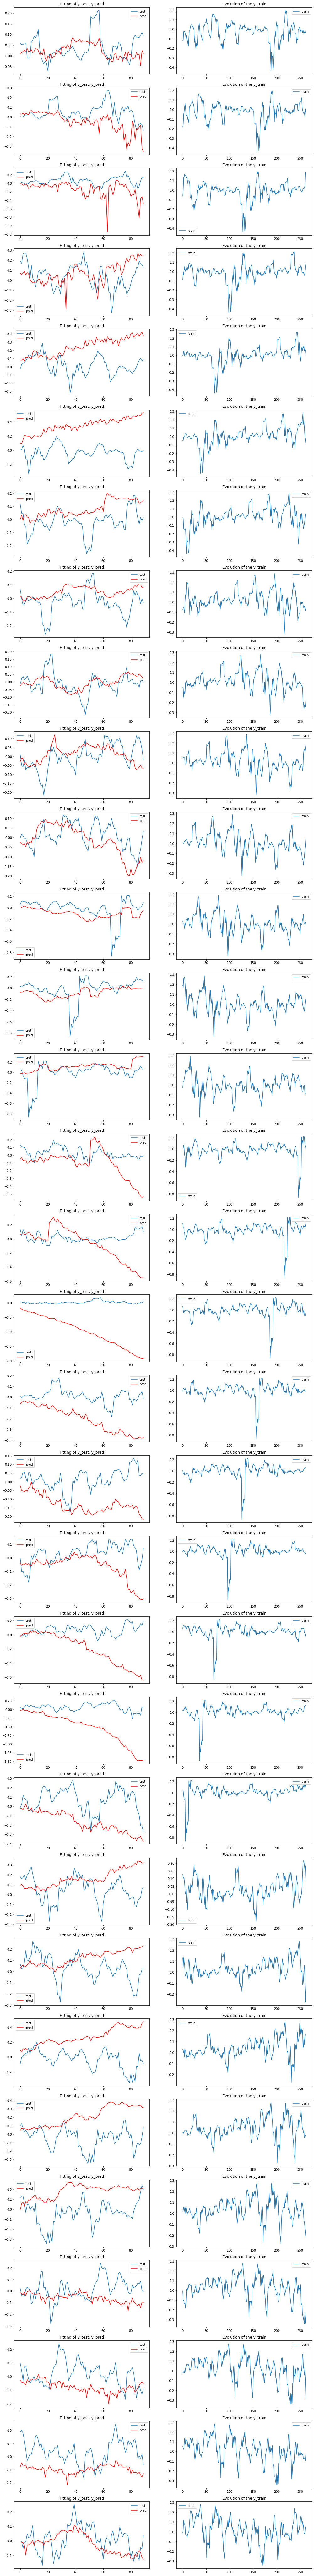

In [17]:
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = 0.01 , l1_ratio = 0.001))

### Plotting scores on cross validated model

In [32]:
def plot_model_scores(model, train_df):
    scores = []
    for counter in range(10):
        #alpha = 0.1 * random()
        #l1 = 0.001 * random()
        # Instanciate model
        model = model
        # Train and Fit data using the crossval
        fold_score, score = train(model,train_df)
        scores = scores.append(score)
    fig, axs = plt.subplots(nrows = range(10), ncols = 1, figsize = (10,12))
    axs[0, 0].plot(scores, label = 'score')
    axs[0, 0].set_title('Model score plot')
    axs[0, 0].legend()

In [33]:
plot_model_scores(LinearRegressionBaselineModel(), train_df)

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.62it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.61it/s]

Training done


AttributeError: 'NoneType' object has no attribute 'append'

In [44]:
model_regression.model.coef_

array([-0.00484787,  0.00606819,  0.00120077, -0.00625006,  0.00289792,
       -0.00061098, -0.0041036 , -0.00219386, -0.00302848,  0.00447554,
        0.02482501, -0.03144319,  0.        , -0.03294256, -0.0132189 ,
        0.00150469, -0.        , -0.        , -0.01634933, -0.01207182,
       -0.00720214, -0.0053081 ,  0.        , -0.01955083, -0.01971913,
       -0.        ,  0.00221509, -0.00876869, -0.00518216, -0.01374838,
        0.0079355 , -0.01207717])

In [45]:
y_pred = model_regression.run(X_test, X_train, y_train)

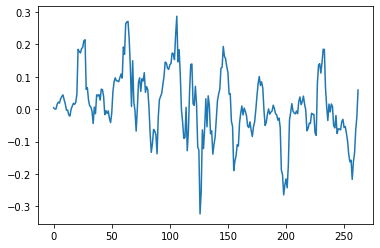

In [46]:
plt.plot(y_train);

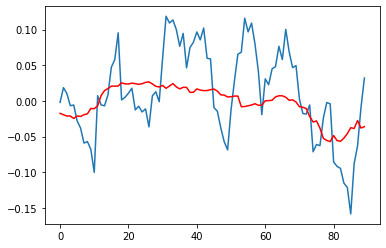

In [47]:
plt.plot(y_test)
plt.plot(y_pred, color = 'r');

## Analysing Coefs

### Elastic Net training

In [17]:
train(model_regression, train_df)
None

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.60it/s]

Training done


### VIF index

In [18]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [19]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [20]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

/Users/chbro/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,vif_index
0,[%]_Bitcoin_growth_rate_on_Horizon=7.1,inf
1,[%]_Bitcoin_growth_rate_on_Horizon=7,inf
2,[+]_[NH]_Circulating_Supply,536.34
3,[$]_[BSB]_Realized_Price,470.79
4,[//]_[AV]_Stock-to-Flow_Ratio,292.45
5,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,272.90
6,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...,256.78
7,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,236.86
8,[+]_[T]_Bitcoin_Price,174.84
9,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,146.87


### Coef matrix

In [34]:
len(train_df.columns)

34

In [35]:
len(model_regression.model.coef_)

32

In [21]:
coeff_matrix = pd.DataFrame(zip(train_df.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

,features,coeff abs
0,[+]_[NH]_Number_of_Addresses_with_Balance_10 -...,0.026993
1,date,0.024846
2,[+]_[NH]_Number_of_Addresses_with_Balance_1k -...,0.020539
3,[+]_[NH]_Issuance,0.019811
4,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_E...,0.018352
5,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),0.018348
6,[+]_[NH]_Days_Till_Halving,0.017226
7,[$]_[BSB]_Realized_Price,0.015904
8,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,0.015739
9,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,0.015637


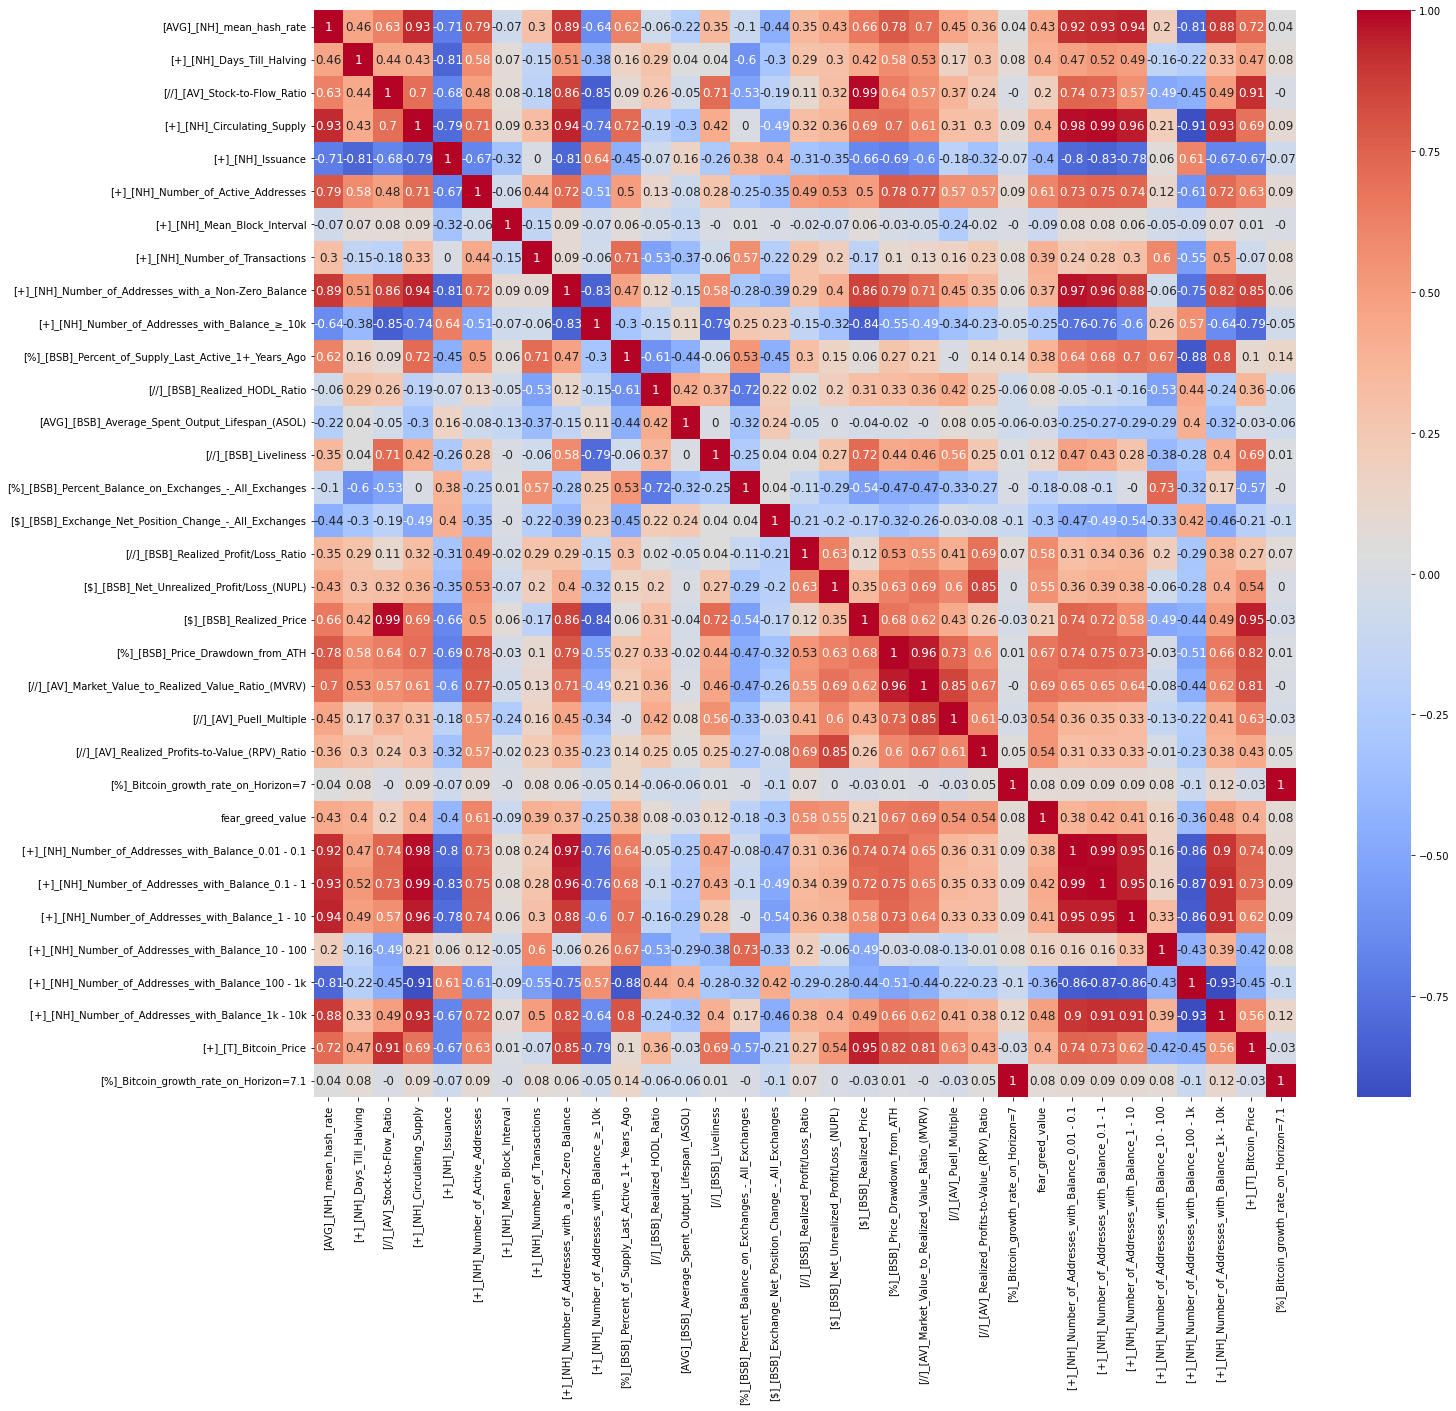

In [22]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [23]:
train_df.corr().style.background_gradient(cmap='coolwarm')

,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago,[//]_[BSB]_Realized_HODL_Ratio,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),[//]_[BSB]_Liveliness,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_Exchanges,[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges,[//]_[BSB]_Realized_Profit/Loss_Ratio,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),[$]_[BSB]_Realized_Price,[%]_[BSB]_Price_Drawdown_from_ATH,[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV),[//]_[AV]_Puell_Multiple,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,[%]_Bitcoin_growth_rate_on_Horizon=7,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7.1
[AVG]_[NH]_mean_hash_rate,1.000000,0.463249,0.629304,0.927169,-0.712801,0.786284,-0.074117,0.302058,0.891591,-0.642719,0.618775,-0.064499,-0.223473,0.346633,-0.099812,-0.436845,0.352598,0.430237,0.658344,0.780710,0.701607,0.454708,0.364717,0.040287,0.425569,0.918749,0.930605,0.943424,0.195707,-0.805297,0.875414,0.719440,0.040287
[+]_[NH]_Days_Till_Halving,0.463249,1.000000,0.436866,0.429619,-0.806056,0.578606,0.065288,-0.149963,0.509130,-0.375290,0.157318,0.289647,0.043345,0.035987,-0.600236,-0.301690,0.293135,0.304622,0.421928,0.576445,0.527764,0.167966,0.303928,0.078466,0.400436,0.468366,0.524204,0.490842,-0.161942,-0.221015,0.328016,0.468988,0.078466
[//]_[AV]_Stock-to-Flow_Ratio,0.629304,0.436866,1.000000,0.699114,-0.677327,0.480246,0.079940,-0.175754,0.862252,-0.854818,0.093373,0.263993,-0.049393,0.706719,-0.526405,-0.188825,0.111765,0.315212,0.987655,0.641723,0.567439,0.371786,0.236555,-0.002152,0.199319,0.740555,0.728599,0.567451,-0.491705,-0.454533,0.488206,0.906993,-0.002152
[+]_[NH]_Circulating_Supply,0.927169,0.429619,0.699114,1.000000,-0.785888,0.713864,0.086502,0.326340,0.937225,-0.742942,0.722878,-0.187891,-0.300747,0.416767,0.003272,-0.487680,0.321386,0.363360,0.692426,0.700705,0.606142,0.311548,0.303061,0.085130,0.397213,0.983180,0.988814,0.956500,0.213877,-0.910185,0.927949,0.692385,0.085130
[+]_[NH]_Issuance,-0.712801,-0.806056,-0.677327,-0.785888,1.000000,-0.667848,-0.320468,0.001851,-0.811983,0.642440,-0.448837,-0.071333,0.158610,-0.263890,0.376395,0.403325,-0.307613,-0.348303,-0.661773,-0.685477,-0.601245,-0.176188,-0.320841,-0.072187,-0.395923,-0.796370,-0.833541,-0.777053,0.062784,0.611022,-0.672405,-0.668343,-0.072187
[+]_[NH]_Number_of_Active_Addresses,0.786284,0.578606,0.480246,0.713864,-0.667848,1.000000,-0.056850,0.435982,0.721753,-0.507995,0.502994,0.127484,-0.075966,0.277955,-0.250108,-0.352278,0.490178,0.530244,0.501975,0.777829,0.767619,0.568422,0.568438,0.085660,0.608574,0.727494,0.752606,0.742655,0.117773,-0.605229,0.724160,0.630475,0.085660
[+]_[NH]_Mean_Block_Interval,-0.074117,0.065288,0.079940,0.086502,-0.320468,-0.056850,1.000000,-0.151192,0.086153,-0.065260,0.060282,-0.048855,-0.127782,-0.002470,0.006885,-0.003950,-0.022173,-0.070328,0.062122,-0.031807,-0.048268,-0.236834,-0.023886,-0.003636,-0.088705,0.080949,0.082551,0.063097,-0.053289,-0.085351,0.067485,0.013416,-0.003636
[+]_[NH]_Number_of_Transactions,0.302058,-0.149963,-0.175754,0.326340,0.001851,0.435982,-0.151192,1.000000,0.094851,-0.060986,0.710054,-0.530734,-0.369053,-0.064918,0.573600,-0.216038,0.286636,0.204831,-0.173771,0.100305,0.127494,0.161846,0.231068,0.077359,0.391888,0.242317,0.277630,0.299953,0.597648,-0.553077,0.500145,-0.067909,0.077359
[+]_[NH]_Number_of_Addr

## Defining Dummy model as baseline

In [24]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
train(dummy_model,train_df)

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.26it/s]

Training done


([104443796.71409,
  136894896.907,
  57789826.1821,
  57571948.57084,
  36307411.5702,
  74567013.08173,
  80072777.50872,
  72418172.60801,
  59181788.0284,
  51308205.40128,
  60591021.98488,
  32626648.07279,
  40880308.76564,
  31323988.01489,
  43549913.06879,
  54124421.99118,
  85738756.0788,
  83004849.74182,
  73315649.9243,
  39252052.61965,
  43965416.36385,
  71334913.00391,
  79765432.61877,
  147999557.83168,
  158509296.47573,
  174562435.88332,
  203875202.18098,
  201701888.36384,
  223167206.73096,
  285640794.51113,
  278941967.31325,
  304205981.32192],
 107769798.10733)

## Elastic Net Tuning

In [25]:
# Instanciate Grid Search
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df)

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.91it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.04it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.11it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.04it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.09it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.06it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.04it/s]

Training done


## RNN tuning

In [28]:
# Instanciate Grid Search
for counter in range(1):
    l1 = random() / 10
    l2 = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1, L2 = l2, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

100%|███████████████████████████████████████████| 32/32 [01:56<00:00,  3.64s/it]

Training done


In [29]:
print(fold_score, score)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] nan


## Exporting and viewing results

In [30]:
df_result = read_result()
df_result.sort_values(by="mean_score", ascending = False)

,name,fold_score,mean_score,min_score,max_score,hyperparams,date
15,Dummy,"[104443796.71409, 136894896.907, 57789826.1821...",1.077698e+08,3.132399e+07,3.042060e+08,NaN,08-03 11:03:45
1,Dummy,"[104443796.71409, 136894896.907, 57789826.1821...",1.077698e+08,3.132399e+07,3.042060e+08,NaN,08-03 11:02:20
0,LinearReg,"[854.24552, 622.42861, 493.03903, 216.84037, 4...",4.092938e+02,1.168868e+02,1.708942e+03,"{'alpha': 0.1, 'l1_ratio': 0.001}",08-03 11:02:14
14,LinearReg,"[854.24552, 622.42861, 493.03903, 216.84037, 4...",4.092938e+02,1.168868e+02,1.708942e+03,"{'alpha': 0.1, 'l1_ratio': 0.001}",08-03 11:03:39
21,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 26.48286261231705, 'l1_ratio': 0.001}",08-03 11:03:58
20,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 26.559064262705206, 'l1_ratio': 0.001}",08-03 11:03:56
16,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 26.63228447585158, 'l1_ratio': 0.001}",08-03 11:03:47
12,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 21.10384470374208, 'l1_ratio': 0.001}",08-03 11:02:44
11,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 25.327487599672015, 'l1_ratio': 0.001}",08-03 11:02:41
9,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 27.354675224599617, 'l1_ratio': 0.001}",08-03 11:02:37


## Notes

In [ ]:
# take mean on the week on linear regression and inspect the weights
# create a btc trajectory on linear trend +2% (test unitaire) => check outcome of strategies in a basic situation
# y_diff to try to improve MAPE
# Check colinearity on coefficients => heatmap ?
# RNN, can try with less features from 2015 if we lack of simples (263 sized sequences, might not be enough)
# l1 is a feature selector that can help tune the RNN
#Feature importance
#if you don't have enough variance, you can leave them out
#Vif analysis on X
#checking the y permutation importance (suffling and checking impact on R2)
#Reco => vif on features & lasso importance
#shuffle on each folds axis = 0 np.array.shuffle()

#keep the mae of the y_diff
#Redo the coeffs
#Finetuning of the models
#plotting distribution of the mae as well